In [93]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
#load the dataset
df = pd.read_csv('amazon_cells_labelled.txt', sep="\t", header=None)
df.columns = ['text', 'sentiment']

df.head()

,text,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [95]:
#df of positive movies
positive_df = df.loc[df.sentiment == 1].reset_index()
#create a dictionary of positive words
words = {}

for i in range(len(positive_df.text)):
    sentence = positive_df.text[i].split(' ')
    for j in range(len(sentence)):
        if (sentence[j].lower() in words):
            words[sentence[j].lower()] += 1
        else:
            words.update({sentence[j].lower() : 1})

In [96]:
#a list of all the positive word counts- numbers here
values = []
for i in words:
    values.append(words[i])
#iterate and find the highest used words
for word in words:
    if (words[word] > np.percentile(values, 92)):
        print('{} : {}'.format(word, round(words[word] / len(words) * 100, 2)))

good : 3.68
excellent : 1.39
great : 4.31
for : 4.51
the : 16.46
is : 9.65
great. : 1.04
you : 1.39
are : 1.46
have : 2.57
and : 13.06
sound : 1.53
quality : 1.46
was : 2.5
very : 4.79
when : 0.49
from : 1.11
battery : 1.39
to : 5.9
highly : 0.56
recommend : 1.25
any : 1.04
one : 1.53
has : 1.67
a : 7.22
phone. : 1.39
so : 1.81
works : 2.99
i : 10.49
bought : 0.56
this : 6.94
use : 0.9
with : 4.31
my : 5.0
new : 0.69
without : 0.49
phone : 3.96
i've : 1.32
can : 0.76
that : 2.08
it's : 1.11
best : 1.32
product : 1.04
like : 1.25
car : 0.56
as : 1.39
well : 1.18
of : 3.4
it : 7.5
up : 0.76
well. : 0.83
case : 0.49
camera : 0.49
nice : 1.32
clear : 0.49
quality. : 0.56
headset : 1.67
bluetooth : 0.69
all : 1.18
does : 0.49
not : 0.97
just : 0.83
pretty : 0.56
had : 1.18
it. : 0.9
love : 1.39
about : 0.49
price : 0.76
even : 0.76
been : 0.83
happy : 0.9
no : 0.83
on : 2.99
really : 1.04
these : 0.83
- : 0.97
they : 0.62
in : 2.36
comfortable : 0.76
than : 1.32
because : 0.62
device : 0.49

## Model 1

In [97]:
keywords = ['good', 'great', 'very', 'excellent', 'best', 'recommend', 'quality', 'love', 'easy', 'happy']

#create columns based on the presence of our keywords
for key in keywords:
    # Note that we add spaces around the key so that we're getting the word, not the pattern
    df[str(key)] = df.text.str.contains(str(key), case=False)

In [98]:
#turn our 0 and 1's into true and false...DON'T RUN AGAIN!!!
df.sentiment = (df.sentiment == 1)

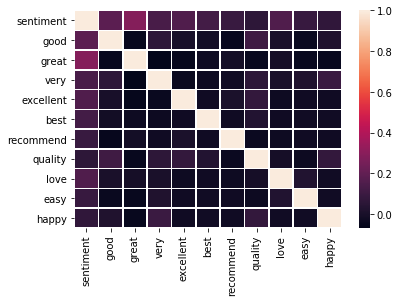

In [99]:
sns.heatmap(df.corr(), linewidth=0.5)
plt.show()

In [100]:
data = df[keywords]
target = df['sentiment']

In [101]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()


In [102]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [103]:
#a function for finding the accuracy, specificity, and sensitivity
def evaluate_model():
    y_pred = bnb.fit(data, target).predict(data)
    tn, fp, fn, tp = confusion_matrix(target, y_pred).ravel()
    print('TN:{}, FP:{} FN:{} TP:{}'.format(tn, fp, fn, tp))
    accuracy = bnb.fit(data, target).score(data, target) * 100
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    print('Our model is {}% accurate.'.format(accuracy))
    print('Our model is {}% specific'.format(specificity))
    print('Our model is {}% sensitive'.format(sensitivity))

In [104]:
#a function to evaluate our model
def evaluate_overfitting():
    print('Testing for Overfitting:') 
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state = 20)
    print('Our train test is {}%'.format(bnb.fit(X_train, y_train).score(X_test, y_test) * 100))
    print('Our overall test is {}%'.format(bnb.fit(data, target).score(data, target) * 100))
    print('')
    print('Testing with Cross Validation:')
    print('{}'.format(cross_val_score(bnb, data, target, cv=10)))
    print('Our average cross validation amount is {}'.format(cross_val_score(bnb, data, target, cv=10).mean()))

In [105]:
evaluate_model()

TN:429, FP:71 FN:194 TP:306
Our model is 73.5% accurate.
Our model is 85.8% specific
Our model is 61.199999999999996% sensitive


In [106]:
evaluate_overfitting()

Testing for Overfitting:
Our train test is 72.0%
Our overall test is 73.5%

Testing with Cross Validation:
[0.8  0.66 0.87 0.7  0.75 0.7  0.73 0.72 0.74 0.66]
Our average cross validation amount is 0.733


So, it doesn't seem that we're succumbing to overfitting. We could do a better job at making our model more sensitive --- correctly identifying what is acutally a positive sentiment. Let's give it a go!

## Model 2

In [107]:
df2 = pd.read_csv('amazon_cells_labelled.txt', sep="\t", header=None)
df2.columns = ['text', 'sentiment']

In [108]:
#create an all caps function to help identify some positives!
df2.text = df.text.apply(lambda x: x.replace('.', ''))
allcaps_list = []

#iterate through each sentence to see if 10% of the words are capitalized
for i in range(len(df2)):
    count = 0
    sentence = df.text[i].split(' ')
    for j in range(len(sentence)):
        if (sentence[j].isupper() and sentence[j] != 'I'):
            count += 1
    allcaps_list.append(count / len(sentence) < 0.1)


df2['allcaps'] = allcaps_list

In [109]:
keywords = ['good', 'great', 'very', 'excellent', 'best', 'recommend', 'quality', 'love', 'easy', 'happy']

#create columns based on the presence of our keywords
for key in keywords:
    df2[str(key)] = df2.text.str.contains(str(key), case=False)

In [110]:
#turn our 0 and 1's into true and false...DON'T RUN AGAIN!!!
df2.sentiment = (df2.sentiment == 1)

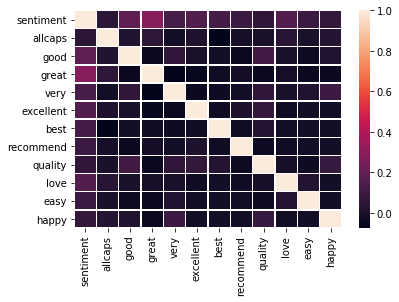

In [111]:
sns.heatmap(df2.corr(), linewidth=0.5)
plt.show()

In [112]:
data = df2[keywords + ['allcaps']]
target = df2['sentiment']

In [113]:
evaluate_model()

TN:433, FP:67 FN:196 TP:304
Our model is 73.7% accurate.
Our model is 86.6% specific
Our model is 60.8% sensitive


In [114]:
evaluate_overfitting()

Testing for Overfitting:
Our train test is 73.0%
Our overall test is 73.7%

Testing with Cross Validation:
[0.82 0.65 0.87 0.69 0.74 0.7  0.73 0.73 0.74 0.66]
Our average cross validation amount is 0.733


Well, this model doesn't seem to succumb to overfitting. We have a trade-off between specificity and sensitivity that we weren't hoping for although a slight increase in accuracy.

## Model 3

In [115]:
df3 = pd.read_csv('amazon_cells_labelled.txt', sep="\t", header=None)
df3.columns = ['text', 'sentiment']

In [116]:
keywords = ['good', 'great']

#create columns based on the presence of our keywords
for key in keywords:
    df3[str(key)] = df.text.str.contains(str(key), case=False)

In [117]:
#turn our 0 and 1's into true and false...DON'T RUN AGAIN!!!
df3.sentiment = (df3.sentiment == 1)

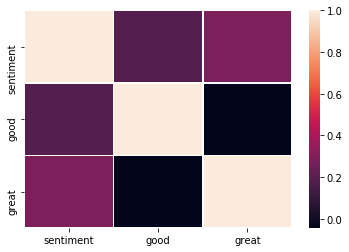

In [118]:
sns.heatmap(df3.corr(), linewidth=0.5)
plt.show()

In [119]:
data = df3[keywords]
target=df3['sentiment']

In [120]:
evaluate_model()

TN:481, FP:19 FN:350 TP:150
Our model is 63.1% accurate.
Our model is 96.2% specific
Our model is 30.0% sensitive


In [121]:
evaluate_overfitting()

Testing for Overfitting:
Our train test is 62.0%
Our overall test is 63.1%

Testing with Cross Validation:
[0.66 0.68 0.68 0.66 0.6  0.66 0.58 0.58 0.64 0.57]
Our average cross validation amount is 0.631


So, it seems that decreasing the amount of features increases our specificity but at the cost of drastic decreases in our sensitivity and accuracy. Let's build a model that increases the amount of features from our first model.

## Model 4

In [122]:
#a list of all the positive word counts- numbers here
values = []
for i in words:
    values.append(words[i])
#iterate and find the highest used words
for word in words:
    if (words[word] > np.percentile(values, 92)):
        print('{} : {}'.format(word, round(words[word] / len(words) * 100, 2)))

good : 3.68
excellent : 1.39
great : 4.31
for : 4.51
the : 16.46
is : 9.65
great. : 1.04
you : 1.39
are : 1.46
have : 2.57
and : 13.06
sound : 1.53
quality : 1.46
was : 2.5
very : 4.79
when : 0.49
from : 1.11
battery : 1.39
to : 5.9
highly : 0.56
recommend : 1.25
any : 1.04
one : 1.53
has : 1.67
a : 7.22
phone. : 1.39
so : 1.81
works : 2.99
i : 10.49
bought : 0.56
this : 6.94
use : 0.9
with : 4.31
my : 5.0
new : 0.69
without : 0.49
phone : 3.96
i've : 1.32
can : 0.76
that : 2.08
it's : 1.11
best : 1.32
product : 1.04
like : 1.25
car : 0.56
as : 1.39
well : 1.18
of : 3.4
it : 7.5
up : 0.76
well. : 0.83
case : 0.49
camera : 0.49
nice : 1.32
clear : 0.49
quality. : 0.56
headset : 1.67
bluetooth : 0.69
all : 1.18
does : 0.49
not : 0.97
just : 0.83
pretty : 0.56
had : 1.18
it. : 0.9
love : 1.39
about : 0.49
price : 0.76
even : 0.76
been : 0.83
happy : 0.9
no : 0.83
on : 2.99
really : 1.04
these : 0.83
- : 0.97
they : 0.62
in : 2.36
comfortable : 0.76
than : 1.32
because : 0.62
device : 0.49

In [123]:
df4 = pd.read_csv('amazon_cells_labelled.txt', sep="\t", header=None)
df4.columns = ['text', 'sentiment']

In [124]:
keywords = ['good', 'great', 'very', 'excellent', 'best', 'recommend', 'quality', 'love', 'easy', 'happy', 'nice', 'better', ]

#create columns based on the presence of our keywords
for key in keywords:
    # Note that we add spaces around the key so that we're getting the word, not the pattern
    df4[str(key)] = df4.text.str.contains(str(key), case=False)

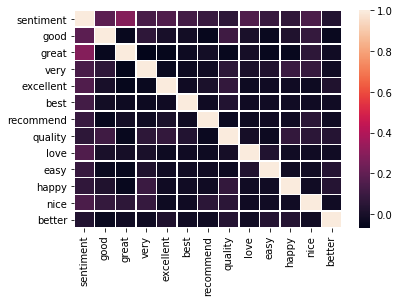

In [125]:
sns.heatmap(df4.corr(), linewidth=0.5)
plt.show()

In [126]:
data = df4[keywords]
target = df4['sentiment']

In [127]:
evaluate_model()

TN:427, FP:73 FN:185 TP:315
Our model is 74.2% accurate.
Our model is 85.39999999999999% specific
Our model is 63.0% sensitive


In [128]:
evaluate_overfitting()

Testing for Overfitting:
Our train test is 72.5%
Our overall test is 74.2%

Testing with Cross Validation:
[0.82 0.69 0.85 0.69 0.78 0.7  0.74 0.72 0.74 0.67]
Our average cross validation amount is 0.74


## Model 5

In [129]:
df5 = pd.read_csv('amazon_cells_labelled.txt', sep="\t", header=None)
df5.columns = ['text', 'sentiment']

In [130]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=10, stop_words='english')
X= vectorizer.fit_transform(df5.text)


In [131]:
#find the top 10 feature names
keywords = vectorizer.get_feature_names()

In [132]:
#build model
for key in keywords:
    df5[str(key)] = df5.text.str.contains(str(key), case=False)

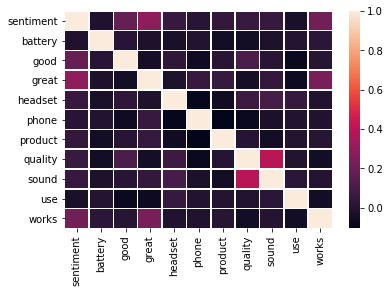

In [133]:
sns.heatmap(df5.corr(), linewidth=0.5)
plt.show()

In [134]:
keywords.remove('sound')

In [135]:
df5.sentiment = (df5.sentiment == 1)

In [136]:
data = df5[keywords]
target = df5['sentiment']

In [137]:
evaluate_model()

TN:448, FP:52 FN:294 TP:206
Our model is 65.4% accurate.
Our model is 89.60000000000001% specific
Our model is 41.199999999999996% sensitive


In [138]:
evaluate_overfitting()

Testing for Overfitting:
Our train test is 64.5%
Our overall test is 65.4%

Testing with Cross Validation:
[0.67 0.69 0.67 0.68 0.62 0.61 0.62 0.63 0.61 0.6 ]
Our average cross validation amount is 0.6399999999999999


## Summary

Well, it seems that increasing the number of features is our best bet by pulling from our commonly used words dictionary. Note, that we still want to use words that make sense for identifying positive sentiment, such as 'good' and 'great' instead of just the most commonly used words.

Our 4th model is the most accurate. It has the most number of features which helps increase our sensitivity which raises overall accuracy. This does decrease overall specificity, but not by as much of a margin as sensitivity.

It's worth noting that, for model 5, we could have looped through our max_features until we found the best model for number of features.